## Практическое задание 1

Попробуйте видоизменить параметры разобранной на уроке нейронной сети таким образом, чтобы улучшить её точность. 

Проведите анализ:

➜ Что приводит к ухудшению точности нейронной сети?   
➜ Что приводит к увеличению её точности?

* [к ответу](#answer)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import random
np.random.seed(28)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

In [2]:
### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = layer2[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1 - sigmoid(x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

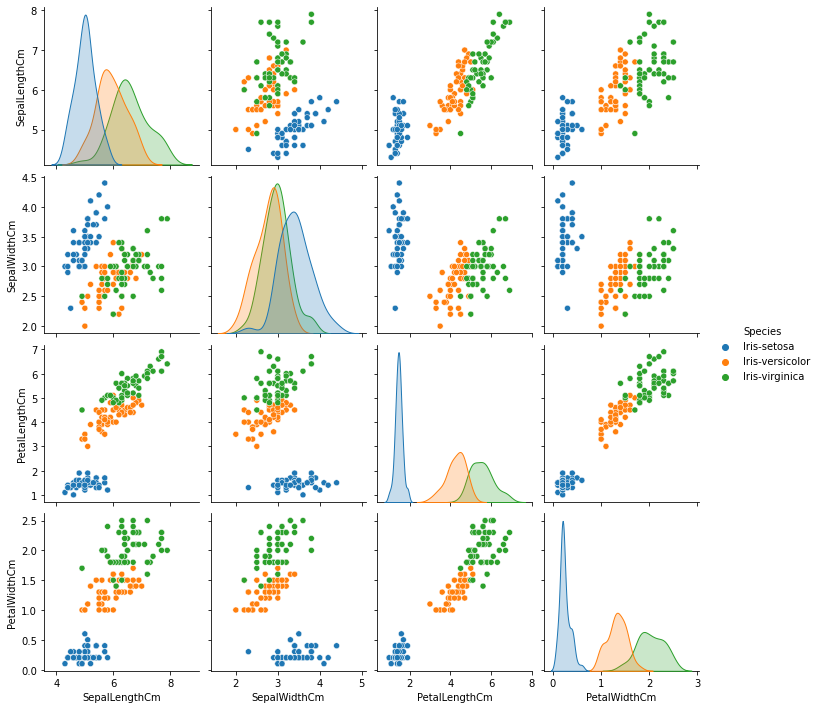

In [3]:
### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")

# репрезентация данных в виде графиков
g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
x = normalize(x.to_numpy())

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
y = y.to_numpy()
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [4]:
### Шаг 3. Обученние нейронной сети

def nn_iris(X_train, y_train, num_layers=2, learning_rate=0.01, num_steps=10000):
    
    # присваивание случайных весов
    if num_layers == 1:
        w = [2*np.random.random((4, 3)) - 1]
    else:
        w = [2*np.random.random((4, 5)) - 1] # для входного слоя   - 4 входа, 5 выходов
        for layer in range(num_layers-2):
            if layer>0:
                w.append(2*np.random.random((5, 5)) - 1) 
        w.append(2*np.random.random((5, 3)) - 1) # для выходного слоя - 5 входов, 3 выхода

    # скорость обучения (learning rate)
    n = 0.01

    # массив для ошибок, чтобы потом построить график
    errors = []

    # процесс обучения
    for i in range(num_steps):

        # прямое распространение(feed forward)
        layer = [X_train]
        for j, weight in enumerate(w):
            layer.append(sigmoid(np.dot(layer[j], weight)))

        # обратное распространение(back propagation) с использованием градиентного спуска
        layer_error = [y_train - layer[-1]]
        layer_delta = [layer_error[0] * sigmoid_deriv(np.dot(layer[-2], w[-1]))]
        if num_layers > 1:
            for j in range(len(layer)):
                try:
                    w_j = w[-j-2]
                    layer_error.append(np.array(layer_delta[j]).dot(np.array(w[-j-1]).T))
                    layer_delta.extend([layer_error[-1] * sigmoid_deriv(np.dot(layer[-j-3], w[-j-2]))])
                except(IndexError):
                    break
        
        for j in range(len(w)):
            w[j] += layer[j].T.dot(layer_delta[-j-1]) * learning_rate

        error = np.mean(np.abs(layer_error[0]))
        errors.append(error)
        accuracy = (1 - error) * 100
        
    return errors, accuracy                                

In [5]:
res = nn_iris(X_train, y_train)

Точность нейронной сети 94.33%


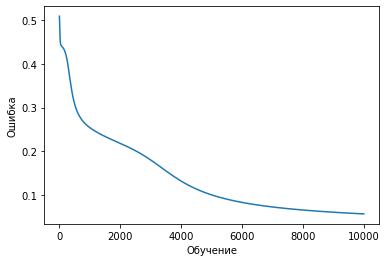

In [6]:
### Шаг 4. Демонстрация полученных результатов
# черчение диаграммы точности в зависимости от обучения
plt.plot(res[0])
plt.xlabel('Обучение')
plt.ylabel('Ошибка')        
print("Точность нейронной сети " + str(round(res[1],2)) + "%")

#### Число слоев

In [7]:
acc_list = []
num_layers = list(range(1, 11))
for num_l in num_layers:
    acc_list.append(nn_iris(X_train, y_train, num_layers=num_l)[1])

Max точность нейронной сети 96.54 % при использовании 5 слоёв


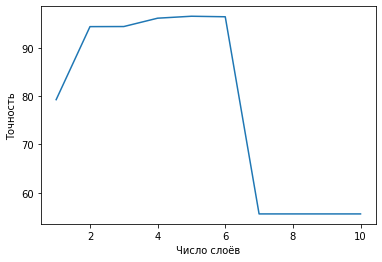

In [8]:
plt.plot(num_layers, acc_list)

plt.xlabel('Число слоёв')
plt.ylabel('Точность')
print(f"Max точность нейронной сети {str(round(max(acc_list),2))} % при использовании {acc_list.index(max(acc_list)) + 1} слоёв")

#### Скорость обучения

In [9]:
acc_list = []
learn_rate = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
for l_rate in learn_rate:
    acc_list.append(nn_iris(X_train, y_train, learning_rate=l_rate)[1])

Max точность нейронной сети 97.52 % при скорости обучения равном 0.5


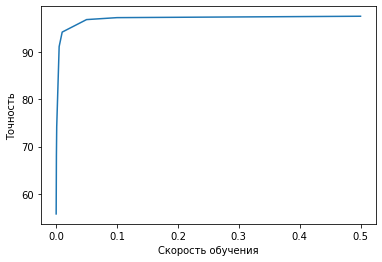

In [10]:
plt.plot(learn_rate, acc_list)

plt.ylabel('Точность')
plt.xlabel('Скорость обучения')
print(f"Max точность нейронной сети {str(round(max(acc_list),2))} % при скорости обучения равном {learn_rate[acc_list.index(max(acc_list))]}")

#### Число итераций

In [11]:
acc_list = []
num_steps = [100, 500, 1000, 3000, 5000, 10000, 30000, 50000]
for num in num_steps:
    acc_list.append(nn_iris(X_train, y_train, num_steps=num)[1])

Max точность нейронной сети 96.78 % при числе итераций равном 50000


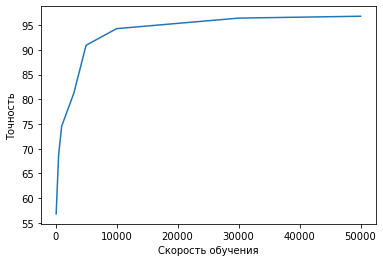

In [12]:
plt.plot(num_steps, acc_list)

plt.ylabel('Точность')
plt.xlabel('Скорость обучения')
print(f"Max точность нейронной сети {str(round(max(acc_list),2))} % при числе итераций равном {num_steps[acc_list.index(max(acc_list))]}")

In [13]:
res = nn_iris(X_train, y_train, num_layers=5, learning_rate=0.01, num_steps=50000)

Точность нейронной сети 97.37%


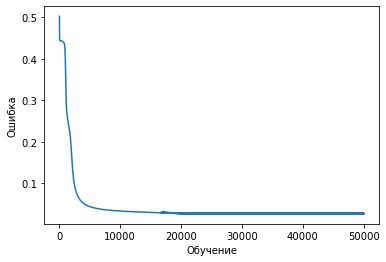

In [14]:
plt.plot(res[0])
plt.xlabel('Обучение')
plt.ylabel('Ошибка')        
print("Точность нейронной сети " + str(round(res[1],2)) + "%")

**Ответ<a class="anchor" id="answer"></a>**

- Увеличение числа слоёв до определённого значения повышает точность, затем она резко снижается
- Очевидно, что чем больше число итераций, тем точнее алгоритм
- Интересно, что на данном датасете увеличение скорости обучения приводит к более точному результату, видимо из-за простоты алгоритм быстро достигает локального минимума